# East Creek Tracer Random Walk Model

#### Developed for GEOB 508 by Conor McDowell 
 (with help from Ellie, David, Marwan, and anyone not named who collected field data)

## Objectives:

          1) Develop a model that can recreate tracer behavior in East Creek during the 
          study period described by Papangelakis et al. (2016).
          2) Use the model to determine:
              a) How does channel morphology affect the virtual velocity of 
              particles through a reach?
              b) What role does channel morphology play in particle dispersion?
              c) How does yearly discharge affect particle dispersion and virtual 
              velocity?
          

## Study Area:

   East Creek is a small gravel-bed stream located in the Malcom Knapp Research Forest maintained by the University of British Columbia (UBC) in western British Columbia. This study focus on two reaches, a rapid reach (RAP) and a riffle-pool reach (RP1), which were also the focus of the Papangelakis et al. (2016) study. In these two sections, East Creek maintains a diameter <4 m wide. Vegetation and cross section analyses identify a Q<sub>bf</sub> of ~2 m<sup>3</sup>/s. While the watershed is heavily forested, forest management research has caused large woody debris (LWD) to be mostly absent from the study reaches, especially when compared with other forests in the Pacific Northwest.
   
   As I have only been to East Creek once, below is a quote from Papangelakis et al. (2016) describing the two study reaches in detail. For reference, a map of the study area with a classification of morphological units is observed in Figure 1.
   
   "Reach-average geometry measurements of the two reaches was done through field surveys, while the grain size distributions of the surface and subsurface material were obtained using the Wolman method (Wolman, 1954) with n ≥100 at various patches along the reaches. RAP is a straight reach of 72m length, a mean bankfull channel width of 2.3±0.4m, a mean bankfull depth of 0.7±0.15 m, and a reach-average slope of 0.02. The surface material has a D50 and D84 of 55 and 105 mm respectively, and the relative roughness of the channel at bankfull is 5.2. 
   
   At the upstream end, the reach has a ~34m long section with minimal bed development and a lack of clear morphological units, classified as ‘rapid’ morphology. Here, the term ‘rapid’ is used as suggested by Zimmerman and Church (2001) to describe featureless gravel channel units with moderate gradients and are the same as those described by Ikeda (1975) andMontgomery and Buffington (1997) as plane-bed morphologies. At the downstream end of RAP, there is a ~39m long sequence of pool-riffle units and alternate bars. Between pool and riffle units, there exist morphological units whose characteristics fall between those of the pool and riffle classifications, and have herein been classified as ‘runs’. RP1 is relatively straight, containing only a few irregular bends. The reach is 117m in length, has a mean bankfull channel width of 2.8 ± 0.9 m, an approximate mean bankfull depth of 0.6 ± 0.1 m, and a reach-averaged slope of 0.018. The surface material of RP1 has a D50 and D84 of 49 and 88mm respectively, and the relative roughness of the channel at bankfull is 6.0. The morphology of RP1 is more developed than that of RAP, containing alternating pool-riffle sequences interspersed by runs, and distinct side bars."

###### Figure 1: East Creek Morphology Map

<img src="Figures/Figure1.png">

Figure 1: A map of East Creek Morphologic Types (from Papangelakis et al. (2016)). RAP and RP1 are delineated by dotted lines and seeding sites are delineated by brackets. Wood (the grey units in the figure) was modelled as pools in this study.

## Data Sources:

   The data used in the development and calibration of the model are the result of multiple long-term monitoring studies conducted by the Hassan Research Group between 2004-2015. Hydrodynamic data was collected in the form of 15-minute interval stage data using a weir just upstream of the study area. Classification of morphological units occured before 2005 through bed surveys and aerial photographs following the classifications outlined in Hassan et al. (2005). 
    
   In 2004, ~1400 uniquely identified magnetic tracer stones were evenly deployed on the riverbed surface between RAP and RP1. The two seeding locations are labelled in Figure 1. These tracers were divided into size classes ranging from <8mm to <90mm and the proportion of each size class was chosen to match the bed subsurface as much as possible. Tracer locations were recorded once a year during the low flow season for every year except for 2009, when no competent flows were recorded. During tracer recovery, downstream and cross-stream locations were recorded along with depth below surface for buried particles. These descriptions also included the morphologic unit of recovery. As the tracer recovery data and East Creek morphology data were collected at different times by multiple researchers, there are some differences between them. For the sake of this study, the tracer data was used to resolve inconsistencies.

## Model Development:

#### Model Overview:
The models developed for this project have been a series of prototypes that use variations of a random walk model to describe sediment movement through the reaches. The first model prototype ignores hydrodynamics, particle size, burial depth, and precise particle location, instead focusing on particle paths from "named morphologic unit" to "named morphologic unit". The second prototype uses "morphologic type" (ex. bar) to determine the potential step length for the next year. Although the second prototype does not yet include hydrodynamic data, burial depth, or an observation-based determination of horizontal movement downstream, those will be included in future prototypes.

** For the purpose of this writeup, a "morphologic unit" is a named location within East Creek (ex. "RAP Riffle 2"). A morphologic type groups these units into similar features (ex. bar, rapid, pool, run, riffle, and trap).

#### Prototype 1
Prototype 1 is an "intentional" recreation of the tracer data collected during a previous study. This model recreates a tracer particle's steps by observing its current morphologic unit and randomly determining the next unit to which it moves. The probability of movement and next location is determined by the movement of all tracers through that morphologic unit during the duration of the study. Since this model is not built on any physical basis and averages across a range of hydrodynamics, relative locations within a morphologic unit, and requires a large amount of observed data, it is not particularly useful for prediction and was instead created for two reasons. The first is to serve as a "non-physical" baseline for future model prototypes. The second is to identify individual morphologic units that may have an outsized impact on tracer virtual velocity. The code for this prototype is in the next few cells. 

Press Shift + Enter to run each cell (the code is written in Python 3).

### The Code for Prototype 1

In [1]:
### Import Required Libraries
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from numpy.random import choice
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
#import os
#INITIAL_DIRECTORY = os.getcwd()

In [2]:
# initialize a helper function to round to nearest .05 (keeps distances reasonable)
def round05(value):
    return np.round(value * 20)/20

In [3]:
# Read list of next step tuples from .txt file
with open('nextsteps.txt') as tuples:
    nextsteps = [(map(str, i.split(','))) for i in tuples]

In [4]:
# turn the list of tuples into a default dictionary
nextsteplocs = defaultdict(lambda: defaultdict(int))
for k, v in nextsteps:
    v = v.strip()
    nextsteplocs[k][v]+=1

# turn the counts of the default dictionary into probabilities
b = []
for i in nextsteplocs:
    a = sum(nextsteplocs[i].values())
    for j in nextsteplocs[i]:
        nextsteplocs[i][j] = nextsteplocs[i][j]/a

In [5]:
# Bring in the ECMorph Dataframe to create a dictionary of {ECLoc : MeanDistance} to 
# calculate distance travelled for each tracer. This associates the mean downstream distance of each
# morphologic unit with the unit name
ECMorph_df = pd.read_csv('ECMorph.csv')
NLGrouped = ECMorph_df.groupby('UNIT_ID')
NamedLocDist_dict = dict(NLGrouped.DSDist.mean())

In [6]:
# Set up stepping function for the model
def nextMU(currentMU):
    cmu = str(currentMU)
    a = []
    b = list(nextsteplocs[cmu].keys())
    for j in nextsteplocs[cmu]:
        a.append(nextsteplocs[cmu][j])
    if not a:
        draw = 'nan'
    if a:
        draw = choice(b, p = a)
    return draw

In [7]:
# turn the stepping function into a repeating model

def MU_Model(numtracers, numyears, startingloc, namedlocdist_dict):
    #initialize df
    modeltracers = pd.DataFrame()
    mtracers = list(range(numtracers))
    modeltracers['tracers'] = mtracers
    modeltracers['CurLoc'] = str(startingloc)
    modeltracers['CurDist'] = str(startingloc)
    modeltracers['t0_dist'] = np.nan
    modeltracers['t0'] = str(startingloc)
    modeltracers['t0_dist'] = modeltracers['t0_dist'].fillna(modeltracers['t0'].map(namedlocdist_dict))
    name1 = 't'
    name2 = '_dist'
    for yr in range(1, numyears):
        tn = []
        name = name1 + str(yr)
        for i in modeltracers['tracers']:
            cloc = modeltracers['CurLoc'][i]
            if cloc == 'nan':
                tn.append('nan')
            else:
                tn.append(nextMU(cloc))
        modeltracers[name] = tn
        modeltracers[name + name2] = np.nan
        modeltracers[name + name2] = modeltracers[name + name2].fillna(modeltracers[name].map(namedlocdist_dict))
        modeltracers['CurLoc'] = tn
        modeltracers['CurDist'] = modeltracers['CurDist'].fillna(modeltracers['CurLoc'].map(namedlocdist_dict))
    return modeltracers

In [8]:
# run the model in the format:
#(number of simulated tracers, number of years, starting location, file containing jump probability)

LocJumpModel = MU_Model(10000, 10, 'RAP_RUN2_SEED', NamedLocDist_dict)

#Adjust the 't9' in 't9_dist' to read 'tx_dist" where is the number of years in the simulation minus 1
LocJumpModel_clean = LocJumpModel.dropna(subset=['t9_dist'])

#Describe the results of transport distances (in meters) in a table
LocJumpModel_clean.describe()

,tracers,t0_dist,t1_dist,t2_dist,t3_dist,t4_dist,t5_dist,t6_dist,t7_dist,t8_dist,t9_dist
count,9858.000000,9.858000e+03,9850.000000,9818.000000,9792.000000,9784.000000,9782.000000,9769.000000,9768.000000,9785.000000,9858.000000
mean,4993.013492,9.402947e+00,28.040350,39.674265,48.964173,56.203425,62.647565,68.243747,73.399970,78.338991,83.352057
std,2885.242358,1.547285e-12,29.320909,34.667845,38.609113,41.304331,44.309428,46.457721,48.550426,50.835496,53.182248
min,0.000000,9.402947e+00,3.282752,3.282752,3.282752,3.282752,3.282752,3.282752,3.282752,3.282752,3.282752
25%,2496.250000,9.402947e+00,9.402947,9.402947,17.331466,23.816234,29.418856,35.102055,41.505587,41.505587,47.166391
50%,4994.500000,9.402947e+00,9.402947,26.952632,41.505587,47.166391,55.710571,61.029241,65.864906,66.287581,71.512102
75%,7487.750000,9.402947e+00,41.505587,61.029241,66.287581,76.830455,81.042915,88.108551,94.533700,99.568243,109.382100
max,9999.000000,9.402947e+00,197.897397,389.401970,408.727510,408.727510,429.469293,389.401970,429.469293,408.727510,429.469293


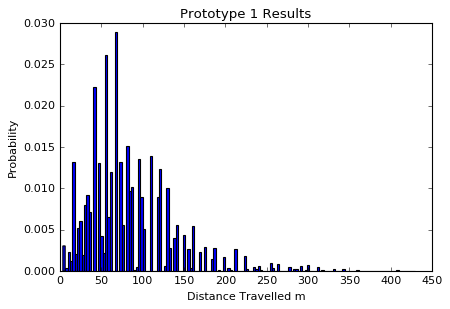

In [9]:
#plot a histogram of finished distances
#adjust the t9_dist to represent your year of choice 
#(typically the number of years in the simulation minus 1)
fig, ax = plt.subplots()
ax.hist(LocJumpModel_clean.t9_dist, 150, normed = True)
ax.set_title('Prototype 1 Results')
ax.plot()
ax.set_xlabel('Distance Travelled m')
ax.set_ylabel('Probability')  

### Prototype 2
East Creek Random Walk Model Prototype 2 operates under a few assumptions:
    
    1) Tracers located in the same morphologic type (bar, pool, etc.) will move similarly. This assumption ignores physical differences both between morphologic units (ex. two different bars) or within a morphologic unit (bar head versus bar tail).
    2) Hydrodynamics and burial depths do not impact tracer movement (this will be added 
      in later prototypes).
    3) Tracer step-length distributions follow either an exponential or gamma distribution (as observed by Phillips et al. (2013) or Hassan and Church (1992)). More extensive 
     model-fitting will be conducted in future prototypes.

Prototype 2 stochastically models yearly tracer travel distance. For each model timestep, tracer step distance is determined by the morphologic unit of the tracer's current location. Its cross-stream position is randomly selected based on its current location, and the two selections together determine its location for the next timestep based on the map of East Creek seen in Figure 1. Further descriptions of this process are located in the next cell.

#### Determination of Step Distances
Six morphologic types were identified during tracer recovery over the 10-year study window: riffle, pool, rapid, run, bar, and trap (an installed bedload transport measurement device). Back Channels, Rip-Rap, and LWD were both observed as possible morphologic units in the East Creek morphological survey, but were not identified during tracer recovery. As a result, Rip-Rap was reclassified as bars, LWD locations were reclassified as pools (although bars may have been a more suitable choice) and back-channel units were excluded from the study.

For each morphologic type, the development of this model focused on the transport behavior of particles which originated within it. This transport behavior was described using two values. The first of these values is the percentage of particles that showed zero forward motion (referred to in the model as "zeroes"), while the second value is a set of parameters that describe the fit of either an exponential model or a gamma model to the group of travel distances originating from the morphologic type over the course of the study. For the exponential function, this takes the form of a "loc" and "scale" parameter, where the probability density function can be parameterized with the equation (y = lambda * exp(-lambda * x)), where scale = 1/lambda. The gamma model also returns a third parameter, a, which serves as a shape parameter. 

Over the 10 years of the study, the percentage of particles with zero movement forward ranged between 30% (riffles) and 43% (traps) depending on morphologic type (Figure 2). This is less than the values reported by Papangelakis et al. (2016) because their study included a 50cm tolerance, whereas this one does not. Figure 3 shows histograms of transport distances originating in each morphologic unit as well as the exponential and gamma models representing them in the random walk model. These model fits did not include the zero values, as the "no movement condition" was explicitly forced in the random walk model (hence the bi-directional behavior of the gamma models for riffles and bars). One will notice that the model fits seem to overpredict particle transport distance. Power-law, Cauchy, and different gamma model fits will be explored in future prototypes.

Given a path and a downstream distance, a modelled tracer was mapped to a morphologic unit (and type) using the map in Figure 1. For each timestep, each tracer particle was assigned a probability of remaining at rest and a distribution of possible movements by the morphologic type in which it sat. Using a weighted random generator, the particle either remained at rest or moved. If the particle moved, a random value, representing step distance, was selected from the model distribution, and added to the location of the particle in the downstream location.

For movement in the cross-stream direction, East Creek was split into five parallel paths upon which the tracers travelled. For each timestep in which a particle moved, that particle had a 50% chance of staying in the same path, and a descending probability of movement into adjacent paths with distance (the probabilities are listed in the "pickline" function in the code below). If there was no listed morphologic unit on that path (either the path left the river boundary or was located in a back-channel unit), the modelled tracer was forced to move one path towards the center. If it still was not in a valid unit, the tracer was dropped and not included in the model or the analysis. 

#### Figure 2: Probability of Zero Movement for each Morphologic Type
<img src="Figures/zeroes_bar.png">
Figure 2: Probability of no forward movement per year for each morphologic type in this study. These values are lower than the values reported by Papangelakis et al. (2016) as this study does not include a 50cm tolerance for motion.

#### Insert Figure 3: Travel Distance Histograms and Models
<img src="Figures/Bar Travel Distances.png">
<img src="Figures/Riffle Travel Distances.png">
<img src="Figures/Pool Travel Distances.png">
<img src="Figures/Rapid Travel Distances.png">
<img src="Figures/Run Travel Distances.png">
<img src="Figures/Trap Travel Distances.png">

Figure 3: Travel distance histograms and model fits for tracer data recorded in the study.

## The Code for Prototype 2

Hit Shift + Enter for each cell in this section

The code is current set up to run either a gamma or exponential distribution model. Unfortunately, I have not yet set it up to run both automatically (or make it easy to switch between the two). I am presenting it to run with the gamma model (as it leads to a more interesting result). If you would like to switch between the two, you will need to change a few lines of code in multiple cells in the model. I will be marking these cells with headings and comments to make it easier.

In [10]:
### Import the neccessary python libraries
import pandas as pd
import numpy as np
import scipy
import scipy.stats
from numpy.random import choice
import matplotlib.pyplot as plt
%matplotlib inline
import os
INITIAL_DIRECTORY = os.getcwd()

In [11]:
### Load in the East Creek Morphologic Unit Data which also includes the Zeroes and Step Parameters
ECMorph_df = pd.read_csv('ECMorph.csv')

##### Adjust the Jump Distribution #1

In [12]:
# For Expon Version, uncomment the line below and comment the gamma line
#ECMorph_df = ECMorph_df[['DSDist', 'Line', 'TYPE', 'UNIT_ID', 'exponparams', 'zeroes']]
# For Gamma Version, uncomment the line below and comment the expon line
ECMorph_df = ECMorph_df[['DSDist', 'Line', 'TYPE', 'UNIT_ID', 'gammaparams', 'zeroes']]

In [13]:
## Initialize the model DataFrame using the code below
def setupdf(testd, years, numtracers, dist):
    # Create the dataframe columns
    assert numtracers % 5 == 0
    dist = str(dist)
    tracers = pd.DataFrame({'Tracer' : list(range(numtracers)),
                            'Distribution' : dist,
                            'DSDist' : testd})
    tracers.ix[0:numtracers/5-1,'Line'] = 'T1'
    tracers.ix[numtracers / 5 : 2 * numtracers / 5 - 1,'Line'] = 'T2'
    tracers.ix[2 * numtracers / 5 : 3 * numtracers / 5 - 1,'Line'] = 'T3'
    tracers.ix[3 * numtracers / 5 : 4 * numtracers / 5 - 1,'Line'] = 'T4'
    tracers.ix[4 * numtracers / 5 : numtracers - 1,'Line'] = 'T5'
    return tracers

In [14]:
## Set up a rounding helper function
def round05(value):
    return np.round(value * 20)/20

In [15]:
## Set up a function to get the MU and Location name based on DSDist and Line
## This line of code matches the model to the East Creek Morphology
def getMULoc(df, morphdf):
    df['DSDist'] = df.DSDist.apply(lambda x: round05(x))
    df = pd.merge(df, morphdf, how = 'left', on = ['Line', 'DSDist'])
    return df

##### Adjust the Jump Distribution #2

In [16]:
## Draw the next step distance for each year. Please note that if you wish to
## change from a gamma to exponential distribution or vice-versa, you must change
## the 'gammaparams' term to 'exponparams' (or vice versa)
def stochdist_zeroes(row):
    # determine whether the particle moves
    jump = choice([0, 1], p = [row['zeroes'], (1-row['zeroes'])])
    # if 'yes' determine the step length
    if jump == 1:
        dist = getattr(scipy.stats, str(row['Distribution']))
        ## Change to 'gammaparams' or 'exponparams' depending on your model choice
        jumplength = np.abs(dist.rvs(*eval(row['gammaparams'])))
    # if 'no' move on to next particle
    else:
        jumplength = 0
    return jumplength

In [17]:
# Preserve data from the previous year by copying the data to another dataframe
def finish_a_year1(df, year):
    yr1 = str(year-1)
    yeardf = pd.DataFrame()
    yeardf['DSDist' + yr1] = df.DSDist.copy()
    yeardf['Line' + yr1] = df.Line.copy()
    yeardf['Increment' + yr1] = df.Increment.copy()
    df = pd.concat([df, yeardf], axis = 1)
    return df

##### Adjust the Jump Distribution #3

In [18]:
# Set up a dataframe for the next Loc Merge by renaming the TYPE and UNITID 
# columns and dropping the parameter and zeroes columns

## To switch from gamma to expon or vice versa, switch gammaparams to exponparams
def finish_a_year2(df, year):
    yr1 = str(year-1)
    TYPENAME = 'TYPE' + yr1
    UNIT_IDNAME = 'UNIT_ID' + yr1
    colname_dict = {'TYPE' : TYPENAME,
                    'UNIT_ID' : UNIT_IDNAME}
    df.rename(columns = colname_dict, inplace = True)
    #switch gammaparams to exponparams if you'd like to switch models
    df = df.drop(['gammaparams', 'zeroes'], axis = 1)
    return df

In [19]:
# Pick the next line given a dictionary of probabilities
def pickline(r):
    ## if there is no particle movement, there is no line switching
    if r['Increment'] == 0:
        endline = r['Line']
    else:
        #The following codeblock determines the probabilities of
        # Movement from one path to the next
        T1_dict = {'T1':.5, 'T2':.3, 'T3':.15, 'T4':.05}
        T2_dict = {'T2':.5, 'T3':.2, 'T1':.2, 'T4':.1}
        T3_dict = {'T3':.5, 'T2':.15, 'T4':.15, 'T5':.10, 'T1':.10}
        T4_dict = {'T4':.5, 'T3':.2, 'T5':.2, 'T2':.1}
        T5_dict = {'T5':.5, 'T4':.3, 'T3':.15, 'T2':.05}
        if r['Line'] == 'T1':
            a = list(T1_dict.keys())
            b = list(T1_dict.values())
        if r['Line'] == 'T2':
            a = list(T2_dict.keys())
            b = list(T2_dict.values())
        if r['Line'] == 'T3':
            a = list(T3_dict.keys())
            b = list(T3_dict.values())
        if r['Line'] == 'T4':
            a = list(T4_dict.keys())
            b = list(T4_dict.values())
        if r['Line'] == 'T5':
            a = list(T5_dict.keys())
            b = list(T5_dict.values())
        endline = choice(a, p = b)
    return endline

In [20]:
##### Adjust the Jump Distribution #4

In [21]:
def check_for_NaNs(df, morphdf, year):
    # extract rows from df that have NaNs
    # This is the brute force version that forces lines with NaNs to adjacent lines
    # switch gammaparams to exponparams or vice versa
    yr1 = str(year - 1)
    LineEscape_dict = {'T1' : 'T2', 
                       'T5' : 'T4', 
                       'T4' : 'T3', 
                       'T2' : 'T3',
                       'T3' : 'T4'}
    if df['TYPE'].isnull().sum() != 0:
        print('checking error in', year)
        df1 = df[df['TYPE'].isnull()]
        ## # switch gammaparams to exponparams or vice versa
        df1 = df1.drop(['TYPE', 'UNIT_ID', 'gammaparams', 'zeroes'], axis = 1)
        for i in range(len(df1)):
            df1['Line'] = df1['Line' + yr1].map(LineEscape_dict)
        df1 = getMULoc(df1, morphdf)
        df = pd.concat([df, df1])
        df = df.dropna(subset=['TYPE'])  
    return(df)

In [22]:
## put the above functions together to run a year
def run_a_year(df, morphdf, year):
    df['Increment'] = df.apply(lambda row: stochdist_zeroes(row), axis = 1)
    df = finish_a_year1(df, year)
    df = finish_a_year2(df, year)
    df['DSDist'] = df['DSDist'] + df['Increment']
    df['Line'] = df.apply(pickline, axis = 1)
    df = getMULoc(df, morphdf)
    df = check_for_NaNs(df, morphdf, year)
    return df

In [23]:
## This line is what runs the model
def ECRW_nohydro(testd, years, numtracers, dist, morphdf):
    # set up dataframe w/ original year
    tracerdf = setupdf(testd, years, numtracers, dist)
    tracerdf = getMULoc(tracerdf, morphdf)
    #assert (tracerdf['TYPE'].isnull().sum() != 0), 'Pick a new downstream distance!'
    # loop through the various steps
    for i in range(1, years):
        print('looping through year', i,'...')
        tracerdf = run_a_year(tracerdf, morphdf, i)
    return tracerdf

### The below line of code actually runs the model

In [24]:
## this block runs a series of tracers that starts in the RAP and RP1 seeding areas
## there are two lines of code (one for each seeding area).

## To initialize the code, select the following (each line is a parameter):
## (downstream distance where 6 == RAP and 91.5 == RP1, 
## number of years where 10 matches the study period,
## number of simulated tracers (needs to be divisible by 5)
## distribution (either 'gamma' or 'expon'), 
## list of morph units (DO NOT CHANGE THIS!!!))

RAP_gamma_10years_test = ECRW_nohydro(6, 10, 1000, 'gamma', ECMorph_df)
RP1_gamma_10years_test = ECRW_nohydro(91.5, 10, 1000, 'gamma', ECMorph_df)

looping through year 1 ...
checking error in 1
looping through year 2 ...
checking error in 2
looping through year 3 ...
checking error in 3
looping through year 4 ...
checking error in 4
looping through year 5 ...
checking error in 5
looping through year 6 ...
checking error in 6
looping through year 7 ...
checking error in 7
looping through year 8 ...
checking error in 8
looping through year 9 ...
checking error in 9
looping through year 1 ...
checking error in 1
looping through year 2 ...
checking error in 2
looping through year 3 ...
checking error in 3
looping through year 4 ...
checking error in 4
looping through year 5 ...
checking error in 5
looping through year 6 ...
checking error in 6
looping through year 7 ...
checking error in 7
looping through year 8 ...
checking error in 8
looping through year 9 ...
checking error in 9


In [25]:
## this block saves outputs to csv if you'd like

# os.chdir(INITIAL_DIRECTORY + '\TestModelOutputs')
# RAP_expon_10years.to_csv('RAP_expon_10years.csv')
# RP1_expon_10years.to_csv('RP1_expon_10years.csv')
# RAP_gamma_10years.to_csv('RAP_gamma_10years_test.csv')
# RP1_gamma_10years.to_csv('RP1_gamma_10years_test.csv')
# os.chdir(INITIAL_DIRECTORY)

## Your Preliminary Model Results

Run the below lines of code to compare your model results to the real data

In [26]:
# Initialize Histogram Plotting
bins = np.linspace(0, 200, 200)

def RAPmodel_data_hist(RAP):
    plt.subplot(121)
    plt.hist(RAP, bins = bins, normed = True)
    plt.title('RAP Model Data')
    plt.xlabel('Distance Traveled', fontsize=15)
    plt.ylabel('Probability', fontsize=15)   

def RP1model_data_hist(RP1):
    plt.subplot(122)
    plt.hist(RP1, bins = bins, normed = True)
    plt.title('RP1 Model Data')
    plt.xlabel('Distance Traveled', fontsize=15)
    plt.ylabel('Probability', fontsize=15) 

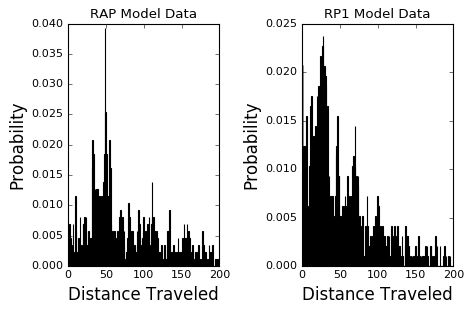

In [27]:
## Plot 'em up (the subtraction allows for calculation of distance travelled)
RAPmodel_data_hist(RAP_gamma_10years_test.DSDist-6)
RP1model_data_hist(RP1_gamma_10years_test.DSDist-91.5)
plt.axis()
plt.tight_layout()
plt.show()

## Presenting Preliminary Data from 100,000 Simulated Tracers:

As an initial model test, 100,000 tracers were simulated over 10 years through the study reaches applying both an exponential and gamma model for step distances. Both models overestimate particle movement through the RAP reach, with the exponential model having a mean particle travel distance of 75.28m and the exponential model having a mean particle travel distance of 82.96m compared with a travel distance of 61.45m for observed tracers. The models perform better through the more morphologically varied RP1, with the exponential model having a mean travel distance of 50.64m and the gamma model having a mean travel distance of 60.69m (compared with 52.32m for the real-world particles). Interestingly, the gamma model does a decent job of recreating particle dispersion, which could be attributed to 1) the lower probability of short travel distances and 2) increased variation between morphologic types. Comparisons between real-world and modelled data for each reach can be observed in Figure 4.

#### Figure 4: Comparison Between Real-World and Modelled Data


##### RAP Tracers
<img src="Figures/hist1.png">
##### RP1 Tracers
<img src="Figures/hist2.png">

Figure 4: Comparison between measured tracer data and the two models used in Prototype 2. Note that while the exponential model does a better job of capturing the mean travel distance of particles, the gamma model does a better job of capturing the relative behavior of the assemblage.

## Future Iterations

While Prototype 2 does a decent job of describing tracer behavior, using the amalgamated step-length data from the study may poorly represent the nature of particle motion. During the tracer study period, 2006 had considerably more discharge than the other years of the study. While other years had between 10% and 40% of tracers mobile, ~90% of tracers were mobile in the 2006-2007 year. For this reason, scaling resting probability and transport distance with discharge (or excess stream power) may better match both the mean and spread of tracer travel distances.